<a href="https://colab.research.google.com/github/ssnirgudkar/UNet/blob/main/IR_200_images_thru_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. no of classes if mentioned 3, then the labels **can only** have values of 0,1 and 2
2. You can check the actual error using CPU, and not GPU
3. softmax is good for image segmentation. it's a probablistic algorithm, so the losses also haev to be accordingly 
4. relu / leakyrelu, adam will work 
5. **Option 1-** leakyrelu - epoc 50, 62 images of which validation images 3. batch size 3 , kernel_initializer = 'he_normal'- , leakyrelu, sparse_categorical_crossentropy: val_loss went from 87 to 0.2. But it was not continually reducing and was fluctutating.  Output segmentation was good. obstacles were showing up.
6. **Option 2- **RELU, epoc 50, total images - 62, validation 3 images, sparse_categorical_crossentropy, kernel_initializer = 'he_normal': Val_loss started from 127 and went to 0.08. was better converging than option 1, but still not always decreasing. Image outpuit better than option1
7. Option 3: 



# Image segmentation with a U-Net-like architecture

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/03/20<br>
**Last modified:** 2020/04/20<br>
**Description:** Image segmentation model trained from scratch on the Oxford Pets dataset.

## Download the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cd "drive/My Drive/PhD/IRLabeledDataset"

Mounted at /content/drive


## Prepare paths of input images and target segmentation masks

In [ ]:
import os

input_dir = "/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized" # directory containing input images
target_dir = "/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_masks_4_resized_relabel_only3wasrclasses" # directory containing segmented images

img_size = (640, 512)
num_classes = 3
batch_size = 3

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

## What does one input image and corresponding segmentation mask look like?

In [ ]:
import cv2
import tensorflow
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
import PIL

img = cv2.imread('/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized/1603388082.940481_resized.png')
print(img) 
img1 = cv2.imread('/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_masks_4_resized_relabel_only3wasrclasses/1603389764.974272_label_ground-truth_resized_relabeled.png', cv2.IMREAD_UNCHANGED)
print(img1)
array1 = tensorflow.keras.preprocessing.image.img_to_array(img)
print(array1) 
array2 = tensorflow.keras.preprocessing.image.img_to_array(img1)
print(array2) 
print(np.unique(array1))
print(np.unique(array2))
print(tensorflow.keras.backend.epsilon())
print(np.unique(cv2.imread('/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_images_4_resized/1603388082.940481_resized.png')))
print(np.unique(cv2.imread('/content/drive/MyDrive/PhD/IRLabeledDataset/ir_train_masks_4_resized_relabel_only3wasrclasses/1603389764.974272_label_ground-truth_resized_relabeled.png',cv2.IMREAD_UNCHANGED)))


In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #9
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

## Prepare `Sequence` class to load & vectorize batches of data

In [30]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            #in case we want to see if masked image have the right values
            #print(tensorflow.keras.preprocessing.image.img_to_array(img))
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2: 
            #if classes are 3, keras expects masked values to be 0,1,2 only. Cannot take 1,3,5. It checks numerically not just the number of masked values
            #y[j] += 1 
        return x, y


## Prepare U-Net Xception-style model

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2 ,padding="same",kernel_initializer = 'he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("ReLU")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("ReLU")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same", kernel_initializer = 'he_normal')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("ReLU")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same", kernel_initializer = 'he_normal')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same", )(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same",  kernel_initializer = 'he_normal')(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("ReLU")(x)
        x = layers.Conv2DTranspose(filters, 3,padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("ReLU")(x)
        x = layers.Conv2DTranspose(filters, 3,padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1,padding="same", kernel_initializer = 'he_normal')(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same",kernel_initializer = 'he_normal')(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

## Set aside a validation split

In [32]:
import random

# Split our img paths into a training and a validation set
val_samples = 3
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Train the model

In [33]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 50
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/50
19/19 [==============================] - 9s 303ms/step - loss: 7.2446 - val_loss: 112.2929
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


19/19 [==============================] - 5s 282ms/step - loss: 0.7956 - val_loss: 63.7773
Epoch 3/50
19/19 [==============================] - 5s 284ms/step - loss: 0.5437 - val_loss: 25.8954
Epoch 4/50
19/19 [==============================] - 5s 283ms/step - loss: 0.1707 - val_loss: 12.1870
Epoch 5/50
19/19 [==============================] - 5s 280ms/step - loss: 1.5649 - val_loss: 21.3472
Epoch 6/50
19/19 [==============================] - 5s 279ms/step - loss: 0.1324 - val_loss: 12.1267
Epoch 7/50
19/19 [==============================] - 5s 277ms/step - loss: 0.1631 - val_loss: 6.1509
Epoch 8/50
19/19 [==============================] - 5s 275ms/step - loss: 0.1215 - val_loss: 9.1938
Epoch 9/50
19/19 [==============================] - 5s 273ms/step - loss: 0.2700 - val_loss: 3.0054
Epoch 10/50
19/19 [==============================] - 5s 273ms/step - loss: 0.0706 - val_loss: 2.0575
Epoch 11/50
19/19 [==============================] - 5s 273ms/step - loss: 0.1166 - val_loss: 1.6681
Epoc

## Visualize predictions

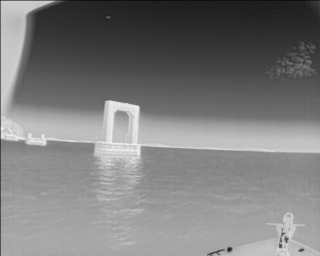

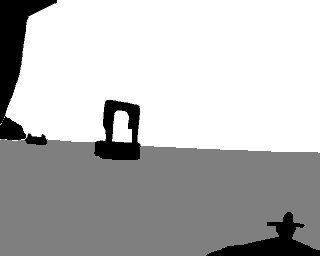

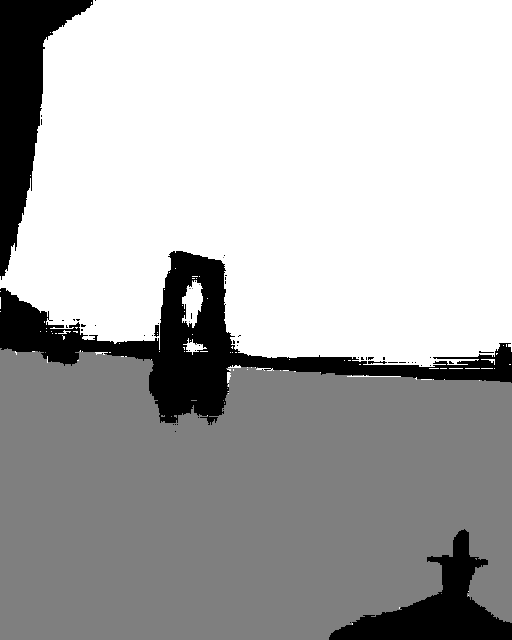

In [36]:
# Generate predictions for all images in the validation set

from IPython.display import Image, display
import PIL
from PIL import ImageOps
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #40. it uses val_inpit_images. so will only pick from the ones that we have kept for validation.
i = 0

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.